For a document with word counts x = (x₁, x₂, ..., xₙ) (where xᵢ is how many times word i appears), the probability of seeing this exact word count pattern if the document belongs to class Cₖ is:

​$$\log P(d|c) = \underbrace{\log \left( \frac{(\sum x_i)!}{\prod x_i!} \right)}_{\text{Constant } K} + \sum x_i \log P(x_i|c)$$
 
​The Goal
Prove that for classification, the Multinomial Naive Bayes posterior probability $P(C_k \mid \mathbf{x})$ is proportional to a linear combination of features:
$$\log P(C_k \mid \mathbf{x}) \propto b_k + \sum_{i=1}^{n} x_i w_{ki}$$
Step 1: The Multinomial Likelihood
We start with the actual probability of seeing a document (or count vector) $\mathbf{x}$ given a class $C_k$:
$$P(\mathbf{x} \mid C_k) = \frac{(\sum_{i=1}^{n} x_i)!}{\prod_{i=1}^{n} x_i!} \prod_{i=1}^{n} p_{ki}^{x_i}$$
![Screenshot 2026-02-21 at 12.04.22 PM.png](<attachment:Screenshot 2026-02-21 at 12.04.22 PM.png>)
Where:$x_i$ is the count of feature $i$ in the sample.$p_{ki}$ is the probability of feature $i$ appearing in class $k$ (e.g., $P(word_i \mid Class_k)$).
Step 2: Bayes' RuleTo find the probability of the class given the data, we use Bayes' Theorem:
$$P(C_k \mid \mathbf{x}) = \frac{P(\mathbf{x} \mid C_k) P(C_k)}{P(\mathbf{x})}$$
In classification, we compare classes for the same input $\mathbf{x}$. Therefore, the denominator $P(\mathbf{x})$ is a constant for all $C_k$. We can ignore it:$$P(C_k \mid \mathbf{x}) \propto P(\mathbf{x} \mid C_k) P(C_k)$$
Step 3: Substitute the LikelihoodNow, substitute the full Multinomial formula into the proportion:
$$P(C_k \mid \mathbf{x}) \propto \underbrace{\left[ \frac{(\sum x_i)!}{\prod x_i!} \right]}_{\text{Part A}} \times \underbrace{\left[ \prod_{i=1}^{n} p_{ki}^{x_i} \right]}_{\text{Part B}} \times \underbrace{P(C_k)}_{\text{Part C}}$$
Crucial Logic Step:
Look at Part A. It consists entirely of $x_i$ (the counts in the input data). It does not contain $k$ (the class).Since Part A is the same value regardless of which class we are testing, it is a constant $K$ relative to the class comparison. We drop it.
$$P(C_k \mid \mathbf{x}) \propto P(C_k) \prod_{i=1}^{n} p_{ki}^{x_i}$$
Step 4: The Log TransformationTo turn this product into a linear sum (and to stay safe in PyTorch with small numbers), we take the natural logarithm of both sides:
$$\log P(C_k \mid \mathbf{x}) \propto \log \left( P(C_k) \prod_{i=1}^{n} p_{ki}^{x_i} \right)$$
Using the log identity $\log(ab) = \log a + \log b$:$$\log P(C_k \mid \mathbf{x}) \propto \log P(C_k) + \log \left( \prod_{i=1}^{n} p_{ki}^{x_i} \right)$$
Using the log identity $\log(a^b) = b \log a$:$$\log P(C_k \mid \mathbf{x}) \propto \log P(C_k) + \sum_{i=1}^{n} x_i \log p_{ki}$$
Step 5: Defining the Linear WeightsNow, we map the terms to the standard linear form $y = b + wx$:
1.Let the Bias be: $b_k = \log P(C_k)$ (The Class Log Prior).
2.Let the Weights be: $w_{ki} = \log p_{ki}$ (The Feature Log Prob).Substituting these back in gives the final linear decision function:
$$\boxed{\log P(C_k \mid \mathbf{x}) \propto b_k + \sum_{i=1}^{n} x_i w_{ki}}$$
Final Interpretation for PyTorchWhen you write torch.matmul(X, W.t()) + b, you are performing exactly this:
The sum $\sum x_i w_{ki}$ is the dot product of your input vector and the class weights.
The $b_k$ is the offset added at the end.

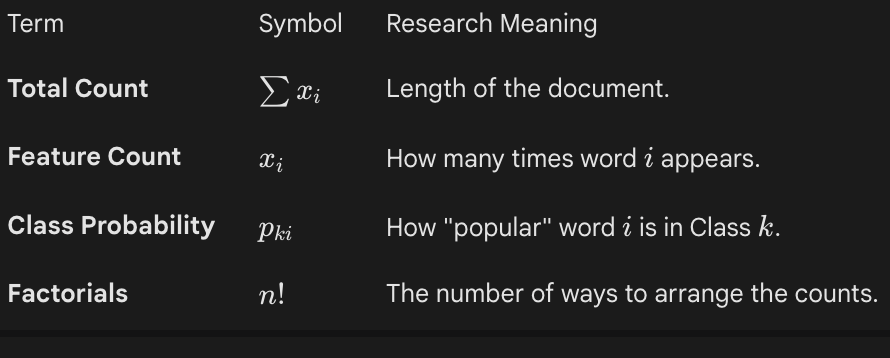